# Using FAISS to Cluster Job Skills Phrases

The first step is to create sample data. I am going to use the sample information from the KMean Clusters. This is done for education purposes. 

In [2]:
cluster1 = ['Experience developing product roadmaps',
 'developing new capabilities',
 'develop creative solutions',
 'build new capabilities',
 'overcome complex systems integration challenges',
 'overcome complex systems integration',
 'power of emerging technologies',
 'principles to developing marketing technology solutions',
 'principles to developing marketing technology',
 'incorporate key technologies']

cluster2 = ['protected by law',
 'participate in certain work',
 'vaccinated against COVID-19',
 'adoption within identified segments',
 'work -related activities',
 'protected under applicable law',
 'serves through programs',
 'responsibility for setting individual',
 'given current COVID19 restrictions',
 'depending on COVID-19 related restrictions']

cluster3 = ['working across global markets',
 'leading through influence',
 'works with product development teams',
 'organization with demonstrated ability',
 'experience managing teams',
 'working with relevant stakeholders',
 'working with technology',
 'involve multiple stakeholder teams',
 'experience leading project',
 'individual manages people']

In [185]:
import spacy
import pandas as pd
import numpy as np
import faiss
import matplotlib.pyplot as plt
from text_util import remove_stop_words
from text_util import token_counter

In [170]:
# Spacy model to convert the phrases in the clusters to vectors
nlp = spacy.load("en_core_web_lg")

In [5]:
phrases = cluster1 + cluster2 + cluster3
phrases[:10]

['Experience developing product roadmaps',
 'developing new capabilities',
 'develop creative solutions',
 'build new capabilities',
 'overcome complex systems integration challenges',
 'overcome complex systems integration',
 'power of emerging technologies',
 'principles to developing marketing technology solutions',
 'principles to developing marketing technology',
 'incorporate key technologies']

In [13]:
vector_phrases = np.array([nlp(p).vector for p in phrases])

In [14]:
vector_phrases

array([[-0.08788   ,  0.10864751,  0.05093225, ...,  0.16550675,
         0.16161324,  0.211032  ],
       [-0.00593667,  0.09985947,  0.02157   , ..., -0.020008  ,
        -0.22197999,  0.38148332],
       [-0.31821832,  0.235391  , -0.12508667, ..., -0.18607335,
         0.05699332,  0.20529866],
       ...,
       [-0.27660277, -0.1703355 , -0.16975951, ..., -0.09986001,
         0.234346  , -0.07670999],
       [ 0.194552  , -0.04580001,  0.07059   , ...,  0.06184734,
        -0.10131234,  0.03543533],
       [-0.12643532,  0.03645667, -0.17206335, ..., -0.35727465,
         0.065333  ,  0.07911543]], dtype=float32)

In [15]:
vector_phrases.shape

(30, 300)

In [16]:
from sentence_transformers import SentenceTransformer
# initialize sentence transformer model
model = SentenceTransformer('all-MiniLM-L12-v2')
# create sentence embeddings
sentence_embeddings = model.encode(phrases)
sentence_embeddings.shape

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/573 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/352 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Ignored unknown kwarg option direction


(30, 384)

In [10]:
type(sentence_embeddings[0])

numpy.ndarray

In [17]:
dimension = sentence_embeddings.shape[1]
print("Vectors dimenstion is {}".format(str(dimension)))

Vectors dimenstion is 384


In [18]:
# Initiate Faiss index
index = faiss.IndexFlatL2(dimension)
index.is_trained

True

In [19]:
index.add(sentence_embeddings)
index.ntotal

30

In [20]:
vector_query = model.encode(["leading team through example"])

Ignored unknown kwarg option direction


In [21]:
%%time
D, I = index.search(vector_query, 5)
print(D)
print(I)

[[0.8828541 0.9400553 0.9919175 1.0196805 1.033725 ]]
[[24 21 22 27 23]]
CPU times: user 6.8 ms, sys: 567 µs, total: 7.36 ms
Wall time: 1.3 ms


In [22]:
type(I)

numpy.ndarray

In [26]:
for i in I[0]:
    print(phrases[i])

experience managing teams
leading through influence
works with product development teams
involve multiple stakeholder teams
organization with demonstrated ability


In [24]:
I[0]

array([24, 21, 22, 27, 23])

In [28]:
## Partition the Index into cells (or clusters)
nlist = 3
quantizer = faiss.IndexFlatL2(dimension)
index = faiss.IndexIVFFlat(quantizer, dimension, nlist)
print(index.is_trained)
index.train(sentence_embeddings)
print(index.is_trained)

False
True


WARNING clustering 30 points to 3 centroids: please provide at least 117 training points


In [29]:
index.add(sentence_embeddings)
index.ntotal

30

In [31]:
%%time
D, I = index.search(vector_query, 5)
print(I)

[[24 21 22 27 23]]
CPU times: user 5.02 ms, sys: 777 µs, total: 5.8 ms
Wall time: 992 µs


In [60]:
MIN_N = 4
MAX_N = 26

#n_clusters = 20
#n_init = 10
#max_iter = 300

kmeans_kwargs = {
    "d": dimension,
    "nredo": 10,
    "niter": 300
}

sse = []
for k in range(MIN_N,MAX_N):
    kmeans = faiss.Kmeans(k = k, **kmeans_kwargs)
    kmeans.train(sentence_embeddings.astype(np.float32))
    sse.append(kmeans.obj[-1])

WARNING clustering 30 points to 4 centroids: please provide at least 156 training points
WARNING clustering 30 points to 5 centroids: please provide at least 195 training points
WARNING clustering 30 points to 6 centroids: please provide at least 234 training points
WARNING clustering 30 points to 7 centroids: please provide at least 273 training points
WARNING clustering 30 points to 8 centroids: please provide at least 312 training points
WARNING clustering 30 points to 9 centroids: please provide at least 351 training points
WARNING clustering 30 points to 10 centroids: please provide at least 390 training points
WARNING clustering 30 points to 11 centroids: please provide at least 429 training points
WARNING clustering 30 points to 12 centroids: please provide at least 468 training points
WARNING clustering 30 points to 13 centroids: please provide at least 507 training points
WARNING clustering 30 points to 14 centroids: please provide at least 546 training points
WARNING clusteri

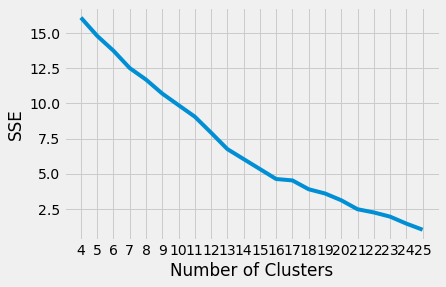

In [61]:
plt.style.use("fivethirtyeight")
plt.plot(range(MIN_N,MAX_N), sse)
plt.xticks(range(MIN_N,MAX_N))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [47]:
D, I = kmeans.index.search(vector_query, 1)
print(I[0][0])
print(D)

2
[[0.7216257]]


In [66]:
from remove_stop_words import remove

In [67]:
print(remove("She like Amazon"))

like Amazon


In [85]:
vector_query = model.encode(["require by law and covid"])
type(vector_query)

Ignored unknown kwarg option direction


numpy.ndarray

In [50]:
for p in phrases:
    ## Compute the phrase vector
    q = model.encode([p])
    _, I = kmeans.index.search(q, 1)
    print("{} --- {}".format(p, str(I[0][0])))

Ignored unknown kwarg option direction
Experience developing product roadmaps --- 0
Ignored unknown kwarg option direction
developing new capabilities --- 0
Ignored unknown kwarg option direction
develop creative solutions --- 0
Ignored unknown kwarg option direction
build new capabilities --- 0
Ignored unknown kwarg option direction
overcome complex systems integration challenges --- 0
Ignored unknown kwarg option direction
overcome complex systems integration --- 0
Ignored unknown kwarg option direction
power of emerging technologies --- 0
Ignored unknown kwarg option direction
principles to developing marketing technology solutions --- 0
Ignored unknown kwarg option direction
principles to developing marketing technology --- 0
Ignored unknown kwarg option direction
incorporate key technologies --- 0
Ignored unknown kwarg option direction
protected by law --- 2
Ignored unknown kwarg option direction
participate in certain work --- 1
Ignored unknown kwarg option direction
vaccinated a

In [68]:
df = pd.read_csv("../data/verb_noun_phrases.csv")

In [72]:
df

,Phrases
0,leads cross-functional teams
1,Manages overall product health
2,achieve broad adoption
3,protected by law
4,working across global markets
...,...
668,incorporated into analytic approaches
669,experience accessing data
670,experience using programming
671,scale distributed computing environments


In [80]:
vectorized_phrases = model.encode([p for p in df["Phrases"]])
vectorized_phrases.shape

Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction


(673, 384)

In [100]:
lv = list(vectorized_phrases)
df["Vectors"] = lv
df.head()

,Phrases,vectors,Vectors
0,leads cross-functional teams,"[-0.03018447, -0.033869676, -0.050169475, -0.0...","[-0.03018447, -0.033869676, -0.050169475, -0.0..."
1,Manages overall product health,"[-0.060903586, 0.0024004246, 0.028241606, -0.0...","[-0.060903586, 0.0024004246, 0.028241606, -0.0..."
2,achieve broad adoption,"[0.0071686516, -0.035724785, 0.022013795, -0.0...","[0.0071686516, -0.035724785, 0.022013795, -0.0..."
3,protected by law,"[0.005880476, 0.09795321, -0.059121605, -0.035...","[0.005880476, 0.09795321, -0.059121605, -0.035..."
4,working across global markets,"[0.026870374, -0.035063125, -0.007222106, -0.0...","[0.026870374, -0.035063125, -0.007222106, -0.0..."


In [81]:
MIN_N = 4
MAX_N = 26

#n_clusters = 20
#n_init = 10
#max_iter = 300

kmeans_kwargs = {
    "d": vectorized_phrases.shape[1],
    "nredo": 10,
    "niter": 300
}

sse = []
for k in range(MIN_N,MAX_N):
    kmeans = faiss.Kmeans(k = k, **kmeans_kwargs)
    kmeans.train(vectorized_phrases.astype(np.float32))
    sse.append(kmeans.obj[-1])

WARNING clustering 673 points to 18 centroids: please provide at least 702 training points
WARNING clustering 673 points to 19 centroids: please provide at least 741 training points
WARNING clustering 673 points to 20 centroids: please provide at least 780 training points
WARNING clustering 673 points to 21 centroids: please provide at least 819 training points
WARNING clustering 673 points to 22 centroids: please provide at least 858 training points
WARNING clustering 673 points to 23 centroids: please provide at least 897 training points
WARNING clustering 673 points to 24 centroids: please provide at least 936 training points
WARNING clustering 673 points to 25 centroids: please provide at least 975 training points


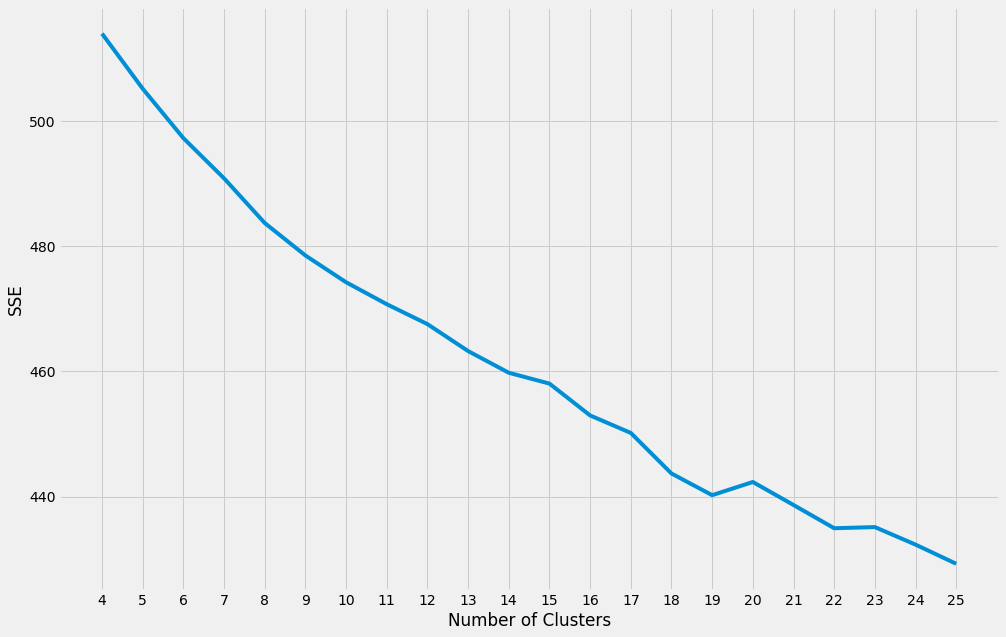

In [83]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,10))
plt.plot(range(MIN_N,MAX_N), sse)
plt.xticks(range(MIN_N,MAX_N))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [90]:
kmeans = faiss.Kmeans(k = 19, **kmeans_kwargs)
kmeans.train(vectorized_phrases.astype(np.float32))
kmeans.index.is_trained

WARNING clustering 673 points to 19 centroids: please provide at least 741 training points


True

In [112]:
def phrase_cluster(text):

    ## the phrase is string
    if type(text) == str:
        q = model.encode([text])
        print(q)
    else:
        q = text
        
    ## Find the cluster assoicate with the phrase
    _, I = kmeans.index.search(q, 1)
    
    return I[0][0]


In [117]:
print(vectorized_phrases[:1])

[[-3.01844701e-02 -3.38696763e-02 -5.01694754e-02 -4.99247126e-02
   1.07682084e-04  2.88850106e-02 -2.43756585e-02 -3.48585024e-02
   3.43238041e-02 -6.81840926e-02 -6.98046312e-02 -2.81668194e-02
   5.99267799e-03 -7.26923533e-03  9.56788138e-02 -4.99622785e-02
  -2.57882345e-02 -4.00707033e-03 -1.82630401e-02 -5.13645634e-02
  -3.91720086e-02 -1.04999058e-02 -1.66784450e-02 -6.61786944e-02
   3.78903723e-03 -5.89902587e-02 -1.11598168e-02  3.27357650e-03
  -1.29699036e-02 -1.10203415e-01 -1.49750877e-02 -6.18758872e-02
  -1.23429680e-02 -1.01607991e-02  2.24123113e-02  1.02868296e-01
  -6.17692620e-02 -1.05512915e-02 -3.18709202e-02 -3.35947089e-02
   1.54521957e-03 -2.24306230e-02  8.77290592e-03 -2.51967963e-02
  -7.08214939e-02 -8.79410654e-02 -5.47903180e-02  7.87791610e-03
  -6.07332587e-02 -4.08924941e-04 -2.43393537e-02 -5.83818629e-02
   1.25129884e-02 -2.33102846e-03  2.23648679e-02  6.89595789e-02
   8.13064575e-02  4.29755747e-02  3.04725878e-02  3.99162509e-02
  -1.08691

In [127]:
np.array([vectorized_phrases[1]])

array([[-6.09035864e-02,  2.40042456e-03,  2.82416064e-02,
        -8.44644196e-03,  4.21605110e-02,  1.33952694e-02,
         8.04270506e-02, -2.72191456e-03, -8.80761221e-02,
        -5.77760078e-02,  9.86451581e-02,  4.16600285e-03,
        -3.12899053e-02, -1.11787496e-02, -1.63373556e-02,
        -3.43125276e-02,  1.01219751e-01, -3.62907015e-02,
         4.20418894e-03, -2.47074831e-02,  1.60753615e-02,
        -2.17761938e-02,  4.69819307e-02, -6.40586764e-03,
        -4.62509133e-02,  5.82236126e-02, -1.52029777e-02,
        -2.06166171e-02,  1.43095839e-03, -3.82853337e-02,
        -1.24042258e-01, -2.04349346e-02,  5.26629314e-02,
         2.37904042e-02, -3.08334827e-02,  2.40538754e-02,
        -3.69842560e-03, -5.95597327e-02, -5.17583154e-02,
        -1.21569075e-02, -4.20120871e-03,  1.14257457e-02,
        -2.74303481e-02, -3.90231088e-02, -2.47461814e-03,
        -4.30614986e-02,  2.61400938e-02, -5.31816706e-02,
         1.03577310e-02,  3.71518321e-02, -1.51023855e-0

In [134]:
df["Clusters"] = df["Vectors"].apply(lambda c: phrase_cluster(np.array([c])))

In [138]:
df = df.drop(columns=["vectors"])
df.head()

,Phrases,Vectors,Clusters
0,leads cross-functional teams,"[-0.03018447, -0.033869676, -0.050169475, -0.0...",7
1,Manages overall product health,"[-0.060903586, 0.0024004246, 0.028241606, -0.0...",0
2,achieve broad adoption,"[0.0071686516, -0.035724785, 0.022013795, -0.0...",16
3,protected by law,"[0.005880476, 0.09795321, -0.059121605, -0.035...",6
4,working across global markets,"[0.026870374, -0.035063125, -0.007222106, -0.0...",6


In [141]:
cluster_list = np.array([c for c in df["Clusters"]])

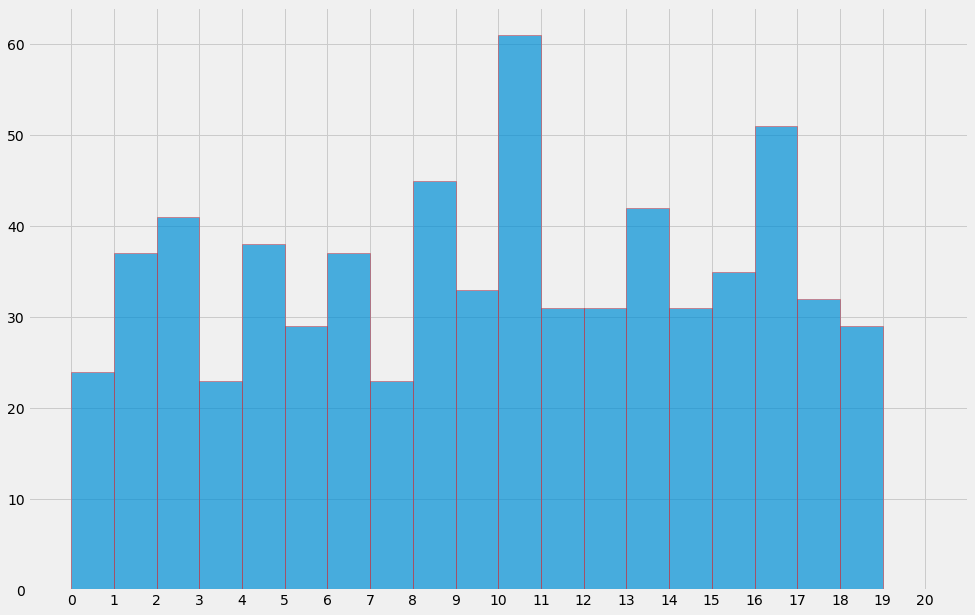

In [156]:
plt.figure(figsize=(15,10))
plt.hist(cluster_list, bins=range(21),ec="red",alpha=0.7,  align='mid')
plt.xticks(range(21))
plt.show()

In [157]:
dfc = df.groupby(["Clusters"])

In [159]:
dfc.get_group(0)

,Phrases,Vectors,Clusters
1,Manages overall product health,"[-0.060903586, 0.0024004246, 0.028241606, -0.0...",0
8,writing comprehensive product epics,"[-0.115708224, -0.031953033, 0.07900626, -0.04...",0
12,works with product development,"[-0.1094693, 0.00775779, 0.054126505, -0.04093...",0
16,Experience developing product roadmaps,"[-0.033489704, -0.083294995, 0.022879334, 0.00...",0
46,bugs of assigned products,"[-0.07492019, -0.05118036, 0.032809064, 0.0098...",0
48,plans of assigned products,"[-0.061229795, -0.022720244, -0.010536698, -0....",0
66,products in consulting projects,"[-0.037009813, -0.009407767, -0.0002593226, 0....",0
84,related to product development,"[-0.098073855, 0.06665912, 0.010557784, -0.028...",0
89,products with satisfying user experiences,"[-0.048511196, -0.00701578, 0.035485495, 0.035...",0
93,excitement for seeing software products,"[-0.09432446, -0.010877746, 0.053646192, -0.03...",0


In [160]:
dfc.get_group(1)

,Phrases,Vectors,Clusters
41,experience leading project,"[0.004391328, -0.041653875, -0.016577872, -0.0...",1
43,experience in executing world,"[-0.0006217085, 0.03524395, -0.0433087, -0.045...",1
45,Experience providing guidance,"[0.050198846, -0.012382353, -0.013040883, 0.04...",1
55,combined with solid business experience,"[0.061225712, 0.07978893, 0.0006501018, 0.0274...",1
70,hone current skills,"[-0.014360291, 0.029374905, 0.013937197, -0.02...",1
76,related additional experience,"[-0.016887784, 0.021289146, 0.020106016, 0.047...",1
105,Experience in managed services,"[-0.004770808, -0.0036775107, -0.069597654, 0....",1
138,continuing professional development,"[-0.024672322, 0.023226442, 0.023119442, 0.016...",1
172,spoken English communication skills,"[0.01498508, -0.00801283, -0.023818573, -0.029...",1
184,sales by conducting training,"[0.02899663, -0.027799593, -0.03936539, 0.0129...",1


In [161]:
dfc.get_group(2)

,Phrases,Vectors,Clusters
10,has several safety protocols,"[0.000977052, -0.01644071, -0.081349, -0.04346...",2
36,serves through programs,"[-0.013939517, -0.010990855, -0.0075142384, -0...",2
42,years of demonstrated delivery,"[-0.046778284, 0.016556667, 0.02819516, -0.026...",2
83,based on needs,"[-0.050038937, 0.0004485121, -0.01601146, -0.0...",2
103,associated ongoing professional service offerings,"[-0.081430204, -0.046180524, 0.027463306, 0.07...",2
132,Use excellent judgment,"[-0.03683993, 0.015736327, -0.071946375, -0.00...",2
145,deliver against goals,"[-0.025876181, 0.017453047, -0.13549373, -0.07...",2
151,ensuring appropriate coverage,"[0.022889996, 0.053581964, -0.0020297086, -0.0...",2
180,portfolio of assigned services,"[0.02201081, -0.05179888, -0.07127647, 6.15781...",2
181,offerings by leading go,"[-0.04925932, -0.09627192, -0.040246367, -0.01...",2


In [162]:
dfc.get_group(3)

,Phrases,Vectors,Clusters
78,overcome complex systems integration,"[-0.10230856, -0.059674416, 0.0123689445, 0.00...",3
79,solving difficult problems,"[0.016117439, 0.055849846, -0.03140352, 0.0069...",3
80,Break down complex problems,"[-0.020473903, 0.027525399, -0.004021621, 0.08...",3
107,dealing with systematic biases,"[-0.053059556, 0.025180057, -0.022113904, -0.0...",3
120,deal with work problems,"[-0.021403862, 0.02130731, -0.025809322, 0.046...",3
127,break down big problems,"[-0.04810626, 0.02408195, -0.01714058, -0.0051...",3
156,solving complex problems,"[-0.0067773927, 0.0464189, 0.009181987, 0.0779...",3
297,troubleshooting with software applications,"[-0.066408746, -0.07426136, -0.0142995175, -0....",3
307,troubleshoot technical issues,"[-0.0441064, -0.01149267, 0.034240134, 0.02805...",3
413,figure out scalable solutions,"[-0.06138308, -0.068622895, -0.030108439, 0.00...",3


In [164]:
len(dfc.groups)

19

In [186]:
for i in dfc.groups:
    print("\nGroup: {}".format(i))
    common_words = token_counter([remove_stop_words(x) for x in dfc.get_group(i)["Phrases"]])
    print(common_words)


Group: 0
Counter({'product': 14, 'products': 9, 'new': 6, 'development': 3, 'developing': 2, 'assigned': 2, 'software': 2, 'leads': 2, 'introduction': 2, 'diagnose': 2, 'monthly': 2, 'performance': 2, 'manages': 1, 'overall': 1, 'health': 1, 'writing': 1, 'comprehensive': 1, 'epics': 1, 'works': 1, 'experience': 1, 'roadmaps': 1, 'bugs': 1, 'plans': 1, 'consulting': 1, 'projects': 1, 'related': 1, 'satisfying': 1, 'user': 1, 'experiences': 1, 'excitement': 1, 'seeing': 1, 'evaluate': 1, 'potential': 1, 'opportunities': 1, 'process': 1, 'monitoring': 1, 'key': 1, 'component': 1, 'lifecycles': 1, 'finance': 1, 'establishing': 1, 'defining': 1, 'future': 1, 'direction': 1, 'metrics': 1, 'communicate': 1, 'delivering': 1, 'manage': 1, 'multiple': 1, 'celebrate': 1, 'diverse': 1, 'contributing': 1, 'codebases': 1})

Group: 1
Counter({'experience': 19, 'skills': 9, 'related': 4, 'developing': 4, 'using': 3, 'conducting': 2, 'training': 2, 'good': 2, 'provide': 2, 'expertise': 2, 'including'

Counter({'data': 29, 'experience': 6, 'analytics': 6, 'advanced': 4, 'including': 3, 'using': 2, 'complex': 2, 'configuring': 2, 'entity': 2, 'base': 2, 'defining': 2, 'governance': 2, 'analysis': 2, 'sets': 2, 'new': 2, 'insights': 2, 'challenges': 2, 'tools': 2, 'implementing': 2, 'privacy': 2, 'work': 2, 'report': 1, 'key': 1, 'metrics': 1, 'vision': 1, 'analyze': 1, 'abap': 1, 'related': 1, 'systems': 1, 'objects': 1, 'stewardship': 1, 'ecosystems': 1, 'management': 1, 'implementations': 1, 'master': 1, 'conduct': 1, 'sophisticated': 1, 'manage': 1, 'large': 1, 'disparate': 1, 'starting': 1, 'raw': 1, 'create': 1, 'resources': 1, 'communicate': 1, 'artifacts': 1, 'languages': 1, 'sql': 1, 'connect': 1, 'external': 1, 'identify': 1, 'questionable': 1, 'driven': 1, 'seek': 1, 'sources': 1, 'needs': 1, 'around': 1, 'tap': 1, 'valuable': 1, 'health': 1, 'care': 1, 'executing': 1, 'science': 1, 'conducting': 1, 'projects': 1, 'extracting': 1, 'architecting': 1, 'organizational': 1, 'int

In [188]:
import nltk
from nltk.util import ngrams
 
# Function to generate n-grams from sentences.
def extract_ngrams(data, num):
    n_grams = ngrams(nltk.word_tokenize(data), num)
    return [ ' '.join(grams) for grams in n_grams]
 
data = 'A class is a blueprint for the object.'
 
print("4-gram: ", extract_ngrams(data, 4))

4-gram:  <zip object at 0x7fe2487bb400>


In [198]:
n_grams = extract_ngrams(data, 4)

In [200]:
for i in n_grams:
    print(i)